# Import right dependencies

In [5]:
import numpy as np
import h5py
import cv2
import numpy
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from keras.datasets import mnist
from sklearn.metrics import classification_report, confusion_matrix

C:\Users\artur\AppData\Roaming\Python\Python313\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


# Import dataset

In [6]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()
print(train_X.shape)
print(train_y.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
(60000, 28, 28)
(60000,)


# One hot encode train and test labels

In [7]:
train_y_one_hot= to_categorical(train_y)
train_y_one_hot = np.einsum('vz->zv', train_y_one_hot)
test_y_one_hot= to_categorical(test_y)
test_y_one_hot = np.einsum('vz->zv', test_y_one_hot)
print(train_X.shape)
print(train_y_one_hot.shape)

(60000, 28, 28)
(10, 60000)


# Flatten and reshape train and test inputs

In [8]:
train_x_flatten = train_X.reshape(train_X.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_X.reshape(test_X.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (784, 60000)
test_x's shape: (784, 10000)


# Define neural network architecture

In [85]:
#input dymension, hidden_layers
# layers_dims = [784, 30, 20, 15, 10]
layers_dims = [784, 128, 64, 10]

# Define activation functions

In [10]:
def relu(z):
    A = np.maximum(0, z)
    cache = z 
    return A, cache

In [12]:
def sigmoid(z):
    s = 1 / (1 + np.exp(-z))    
    cache = z
    return s, cache

In [13]:
def softmax(z):
    cache = z 
    z_norm = z - np.max(z)
    exp = np.exp(z_norm)
    exp = exp / np.sum(exp, axis=0, keepdims=True)
    return exp, cache

# Define forward propagation functions

In [86]:
def initialize_parameters_deep(layer_dims):
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))

    return parameters

In [15]:
def linear_forward(A, W, b):
    Z = np.dot(W, A) + b
    cache = (A, W, b)
    return Z, cache

In [16]:
def linear_activation_forward(A_prev, W, b, activation):
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)        
        A, activation_cache = sigmoid(Z) 
    
    elif activation == "softmax":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = softmax(Z)
    
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    cache = (linear_cache, activation_cache)

    return A, cache

# Define model forward function

In [58]:
def L_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2            

    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation="relu")
        caches.append(cache)
    
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation="softmax")
    caches.append(cache)
    
    return AL, caches

# Define cost functions

In [60]:
def compute_cost(AL, Y):
    m = Y.shape[1]
    # cost = -np.mean(Y * np.log(AL))
    # cost = np.squeeze(cost)
    cost = -1/m * np.sum(Y * np.log(AL))
    return cost

# Define activation function derivatives with respect to loss

In [61]:
def sigmoid_backward(dA, cache):
    Z = cache 
    s = 1 / (1 + np.exp(-Z))    
    dZ = dA * s * (1-s)
    return dZ

In [62]:
def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True) 
    dZ[Z <= 0] = 0
    return dZ

# Define backward propagation functions

In [63]:
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]
    dW = np.multiply(1/m,np.dot(dZ, A_prev.transpose()))
    db = np.multiply(1/m,np.sum(dZ, axis = 1, keepdims = True))
    dA_prev = np.dot(W.transpose(),dZ)

    return dA_prev, dW, db

In [64]:
def linear_activation_backward(dA, cache, activation):

    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)        
        dA_prev, dW, db = linear_backward(dZ, linear_cache)

    elif activation == "softmax":
        dZ = softmax_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

# Define model backward function

In [87]:
def L_model_backward(AL, Y, caches):

    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    
    dAL = (AL - Y)
    
    current_cache = caches[L-1]
    dA_prev_temp, dW_temp, db_temp = linear_activation_backward(dAL, current_cache, "sigmoid")
    grads["dA" + str(L-1)] = dA_prev_temp
    grads["dW" + str(L)] = dW_temp
    grads["db" + str(L)] = db_temp
    
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l+1)], current_cache, "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l+1)] = dW_temp
        grads["db" + str(l+1)] = db_temp

    return grads

In [46]:
def update_parameters(params, grads, learning_rate):
    parameters = params.copy()
    L = len(parameters) // 2 
    for l in range(L):
        parameters["W" + str(l+1)] = params["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = params["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
    return parameters

# Define model

In [88]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.9, num_iterations = 3000, print_cost=False):

    np.random.seed(1)
    costs = []                         # keep track of cost
    parameters = initialize_parameters_deep(layers_dims)

    for i in range(0, num_iterations):
        AL, caches = L_model_forward(X, parameters)
        cost = compute_cost(AL, Y)
        grads = L_model_backward(AL, Y, caches)
        parameters = update_parameters(parameters, grads, learning_rate)
                
        # Print the cost every 100 iterations
        if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost)
    
    return parameters, costs

# Train model

In [91]:
parameters, costs = L_layer_model(
    train_x, 
    train_y_one_hot, 
    layers_dims, 
    learning_rate = 0.05, 
    num_iterations = 2500, 
    print_cost = True
)

Cost after iteration 0: 2.3258322321509444
Cost after iteration 100: 2.075515143548707
Cost after iteration 200: 1.6833400051458658
Cost after iteration 300: 1.2751738936239427
Cost after iteration 400: 0.9942623857847371
Cost after iteration 500: 0.8215739646120495
Cost after iteration 600: 0.7106507442083091
Cost after iteration 700: 0.6347156820053255
Cost after iteration 800: 0.5797229662650485
Cost after iteration 900: 0.5380779464689168
Cost after iteration 1000: 0.5054247278624568
Cost after iteration 1100: 0.47910220114561436
Cost after iteration 1200: 0.45741542640486504
Cost after iteration 1300: 0.43921297926105607
Cost after iteration 1400: 0.4236984634623766
Cost after iteration 1500: 0.410299290948972
Cost after iteration 1600: 0.3985847236141034
Cost after iteration 1700: 0.38823571986000693
Cost after iteration 1800: 0.3790099944949947
Cost after iteration 1900: 0.37072094971666303
Cost after iteration 2000: 0.3632097078958633
Cost after iteration 2100: 0.35636754510770

# Define function for predictions and their accuracy

In [67]:
def predict(X, y, parameters):
    m = X.shape[1]
    n = len(parameters) // 2
    p = np.zeros((1,m))
    
    probas, caches = L_model_forward(X, parameters)
    return np.argmax(probas, axis=0)    

In [68]:
def accuracy(y, y_hat):
    acc = np.sum(y==y_hat)/len(y)
    return acc

# Make predictions on training data, get accuracy

In [92]:
pred_train = predict(train_x, train_y, parameters)

In [93]:
accuracy(train_y, pred_train)

np.float64(0.9116333333333333)

# Print confusion matrix and classification report for train predictions

In [94]:
print(confusion_matrix(train_y, pred_train))
print(classification_report(train_y, pred_train))

[[5675    0   25   13   10   58   47   11   80    4]
 [   0 6541   38   28    5   37    9   20   51   13]
 [  50   60 5252   85  115   18  124   91  137   26]
 [  26   33  148 5356    4  247   33   81  140   63]
 [   9   32   30    3 5392    3   76    7   35  255]
 [  78   43   42  200   78 4667  104   22  126   61]
 [  46   21   51    2   42   71 5642    1   41    1]
 [  36   50   93   20   78   10    4 5759   18  197]
 [  27  105   74  157   35  131   57   18 5145  102]
 [  42   29   27   91  207   42    7  176   59 5269]]
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      5923
           1       0.95      0.97      0.96      6742
           2       0.91      0.88      0.89      5958
           3       0.90      0.87      0.89      6131
           4       0.90      0.92      0.91      5842
           5       0.88      0.86      0.87      5421
           6       0.92      0.95      0.94      5918
           7       0.93      0.92   

# Make predictions on test data, get accuracy

In [95]:
pred_test = predict(test_x, test_y, parameters)
accuracy(test_y, pred_test)

np.float64(0.9172)

# Print confusion matrix and classification report for test predictions

In [96]:
print(confusion_matrix(test_y, pred_test))
print(classification_report(test_y, pred_test))

[[ 956    0    2    2    0    8    8    1    3    0]
 [   0 1108    3    4    0    2    4    1   13    0]
 [  12    1  915   15   19    0   16   17   33    4]
 [   3    0   21  912    1   28    4   16   18    7]
 [   1    2    5    0  913    1   12    2    7   39]
 [  12    3    6   42   13  765   16    6   20    9]
 [  12    3    4    0   10   13  912    0    4    0]
 [   4   10   28    4   12    2    0  933    3   32]
 [   7    6    9   25   11   23   14   11  859    9]
 [  11    7    3   11   40   14    1   17    6  899]]
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       980
           1       0.97      0.98      0.97      1135
           2       0.92      0.89      0.90      1032
           3       0.90      0.90      0.90      1010
           4       0.90      0.93      0.91       982
           5       0.89      0.86      0.88       892
           6       0.92      0.95      0.94       958
           7       0.93      0.91   

# Plot part of the incorrectly predicted images and append them to list

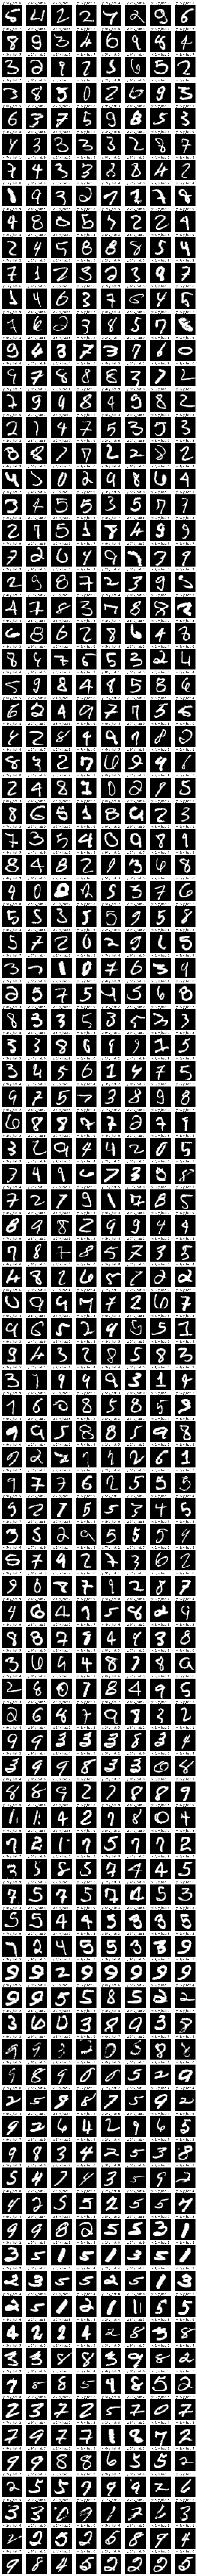

In [ ]:
fig = plt.figure(figsize=(15,200))
z = 0
incorrect_list = []

for i in range(len(test_y)):
    y = test_y[i]
    y_hat = pred_test[i]
    
    if (y != y_hat):
        z += 1
        incorrect_list.append(i)
        
        if z <= 800:
            ax = fig.add_subplot(100, 8, z)
            ax.imshow(test_X[i], cmap=plt.get_cmap('gray'))
            
            ax.set_title('y: {y}/ y_hat: {y_hat}'
                         .format(y=test_y[i], y_hat=pred_test[i]))
            plt.axis('off')


# Define function for getting derivative of loss with respect to input for saliency maps

In [61]:
def get_saliency_map(X, y, parameters):
    m = X.shape[1]
    n = len(parameters) // 2
    p = np.zeros((1,m))
    
    probas, caches = L_model_forward(X, parameters)
    cost = compute_cost(probas, y)
    grads = L_model_backward(probas, y, caches)
    dy_dx = grads["dA0"]

    return np.argmax(probas, axis=0), dy_dx

# Prepare incorrectly predicted data for saliency maps 

In [62]:
saliency_test = test_x[:, incorrect_list]
saliency_test.reshape(saliency_test.shape[0],len(incorrect_list))
print(saliency_test.shape)

saliency_test_y = test_y[incorrect_list]
print(saliency_test_y.shape)

test_y_one_hot_for_saliency = to_categorical(saliency_test_y)
test_y_one_hot_for_saliency = np.einsum('vz->zv', test_y_one_hot_for_saliency)

(784, 420)
(420,)


# Get predictions and derivative of loss with respect to input

In [63]:
probas, dy_dx = ...................

# Reshape and normalize results for plot 

In [64]:
dy_dx_one_rs = dy_dx.reshape(28,28,dy_dx.shape[1])

normalized_tensor = np.multiply(
    255, (((dy_dx_one_rs - np.min(dy_dx_one_rs))
    / (np.max(dy_dx_one_rs) - np.min(dy_dx_one_rs)))))

# Apply penalty for smaller values

In [65]:
log = (1/(1+np.log((np.max(normalized_tensor) - normalized_tensor + 0.0001))))
normalized_tensor_weighted = np.multiply(normalized_tensor,log)

# The brightest points show the highest impact on loss

In [1]:
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.imshow(normalized_tensor_weighted[:,:,1], cmap='gray')
plt.show()

NameError: name 'plt' is not defined

# Darken the prediction images so saliency points become the brightest ones in image

In [81]:
saliency_test = test_x[:, incorrect_list]
saliency_test.reshape(saliency_test.shape[0],len(incorrect_list))
saliency_test = saliency_test.reshape(28,28,saliency_test.shape[1])
saliency_test = np.multiply(
    20, (saliency_test - np.min(saliency_test))
    / (np.max(saliency_test) - np.min(saliency_test))
)

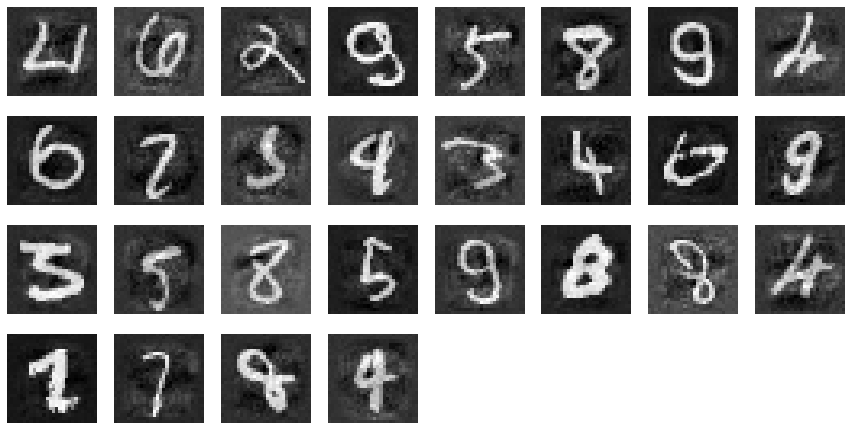

In [82]:
fig = plt.figure(figsize=(15,200))
z = 0
for i in range(saliency_test.shape[1]):
    z += 1
    picture_i = saliency_test[:,:,i]
    saliency_map_i = normalized_tensor_weighted[:,:,i]
    ax = fig.add_subplot(100, 8, z)
    super_imposed = cv2.addWeighted(picture_i, 0.5, saliency_map_i, 0.5, 0.0, dtype=cv2.CV_64F)
    ax.imshow(super_imposed, cmap=plt.get_cmap('gray'))
    
    plt.axis('off')